## BUGS

## TODO
- work on MixtureParamsMLP to output the right dimensions 
- how to print out trace for pi

In [1]:
import numpy as np
import time

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.nn import PyroModule

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline

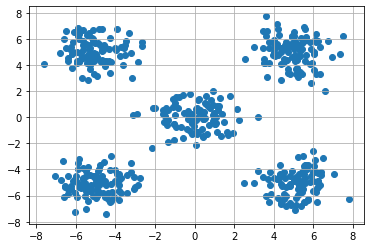

In [2]:
N = 500  # number of data points
M = 2  # number of features
T = 5  # Fixed number of components.

cov = np.identity(M)  # covariance matrix is just the identity for now

# generate data
clust1 = np.random.multivariate_normal(np.zeros(M), cov, 100)
clust2 = np.random.multivariate_normal(np.ones(M)*5, cov, 100)
clust3 = np.random.multivariate_normal(np.ones(M)*-5, cov, 100)
clust4 = np.random.multivariate_normal([5, -5], cov, 100)
clust5 = np.random.multivariate_normal([-5, 5], cov, 100)
data = np.concatenate((clust1, clust2, clust3, clust4, clust5))

plt.scatter(data[:,0], data[:,1])
plt.grid()

data = torch.from_numpy(data).float()  # convert numpy to torch

In [3]:
class MixtureMLP(PyroModule):
  '''
    PointNet inspired nn architecture for permutation invariance
    GitHub repo: https://github.com/fxia22/pointnet.pytorch/blob/f0c2430b0b1529e3f76fb5d6cd6ca14be763d975/pointnet/model.py#L11
    Paper: https://arxiv.org/pdf/1612.00593.pdf
  '''
  def __init__(self, output_size, M, softmax=True):
    super().__init__()
    
    self.output_size = output_size
    self.M = M
    
    self.t_net = nn.Sequential(
        nn.Conv1d(self.M, 64, 1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        
        nn.Conv1d(64, 128, 1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        
        nn.Conv1d(128, 1024, 1),
        nn.BatchNorm1d(1024),
        nn.ReLU()
    )
    
    self.fully_connected = nn.Sequential(
        nn.Linear(1024, 512),
        # nn.BatchNorm1d(512),  # don't need batchnorm for only 1 batch
        nn.ReLU(),
        
        nn.Linear(512, 256),
        # nn.BatchNorm1d(256),
        nn.ReLU(),
        
        nn.Linear(256, self.output_size)
    )
    
    self.softmax = nn.Softmax(1)

  def forward(self, x):
    x = self.t_net(x[None,:,:])
    x = torch.max(x, 2, keepdim=True)[0]  # maxpooling layer
    x = x.view(-1, 1024)
    
    x = self.fully_connected(x)
    
    if self.softmax:
        x = self.softmax(x)        
        
    return x.squeeze()  # remove any 1-d axes

In [4]:
def model(data):
    # global variables
    alpha = torch.ones(T)
    weights = pyro.sample('weights', Dirichlet(alpha))
    
    # locs = None
    with pyro.plate('components', T):
        locs = pyro.sample('locs', MultivariateNormal(torch.zeros(M), torch.eye(M)))
        # locs = curr
        
    # locs = pyro.sample('locs', MultivariateNormal(torch.zeros(T, M), torch.eye(M)))
    print('model locs', locs)
    print('model locs shape', locs.shape)

    # local variables
    with pyro.plate('data', N):
        assignment = pyro.sample('assignment', Categorical(weights))
        pyro.sample('obs', MultivariateNormal(locs[assignment], torch.eye(M)), obs=data)
    # assignments = pyro.sample('assignments', Categorical(weights).expand([N]).independent(1))
    # for i in pyro.plate('data', N):
    #     pyro.sample('obs_{}'.format(i), MultivariateNormal(locs[assignments[i]], torch.eye(M)), obs=data[i])
        
    # with pyro.plate('data', N):
    #     # Local variables.
    #     assignments = pyro.sample('assignments', Categorical(weights)) # returns a vector of length T
    #     obs = pyro.sample('obs', MultivariateNormal(locs[assignments], torch.eye(M)), obs=data)
        
def guide(data):
    # amortize using MLP
    pyro.module('alpha_mlp', alpha_mlp)
    pyro.module('tau_mlp', tau_mlp)
    
    # sample mixture components mu
    tau = tau_mlp(data.permute(1,0).float())
    tau = tau.view(5,2)  # reshape tensor
    print('guide tau', tau)
    print('guide tau.shape', tau.shape)
    
    pyro.sample('locs', MultivariateNormal(tau, torch.eye(M)))
    
    # for i in pyro.plate('components', T):
    #     pyro.sample('locs_{}'.format(i), MultivariateNormal(tau[i], torch.eye(M)))
    
    # sample cluster assignments
    alpha = alpha_mlp(data.permute(1,0).float()) # returns a vector of length T
    weights = pyro.sample('weights', Dirichlet(alpha))  # vector of length T
    with pyro.iarange('data', N):
        pyro.sample('assignment', Categorical(weights))

In [5]:
def print_progress(step):
    print('='*10, 'Iteration {}'.format(step), '='*10)
    tau = pyro.param('tau')
    # weights = pyro.param('weights')
    

    print('tau is', tau)
    # print('weights is', weights)

In [6]:
alpha_mlp = MixtureMLP(T, M).float()  # variational parameters for mixture proportions pi
tau_mlp = MixtureMLP(T*M, M, softmax=False).float() 

adam_params = {"lr": 0.005}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 2500
start = time.time()
for step in range(n_steps):
  svi.step(data)
  pyro.get_param_store()
  if step % 100 == 0:
        end = time.time()
        print_progress(step, data)
        print('took', end-start, 'seconds')
        start = time.time()

guide tau tensor([[0.1181, 0.1316],
        [0.0751, 0.1187],
        [0.0593, 0.1048],
        [0.0972, 0.0997],
        [0.1229, 0.0727]], grad_fn=<ViewBackward>)
guide tau.shape torch.Size([5, 2])
model locs tensor([[-0.4795,  0.0434],
        [ 0.3450, -1.3360],
        [-0.8174, -0.1952],
        [-0.5978,  0.5593],
        [-0.4370, -0.1991]], grad_fn=<AddBackward0>)
model locs shape torch.Size([5, 2])


ValueError: at site "locs", invalid log_prob shape
  Expected [], actual [5]
  Try one of the following fixes:
  - enclose the batched tensor in a with pyro.plate(...): context
  - .to_event(...) the distribution being sampled
  - .permute() data dimensions